#1. Data discretization

1.1 Loading data

In [1]:
import pandas as pd
import re

df = pd.read_csv('boston_data.csv')
df.info()
y = df['MEDV']
X = df.drop(columns=['MEDV', 'CHAS', 'RAD', 'NOX', 'RM', 'DIS', 'B'])

print(X.info())
print(y.head())

# df = pd.read_csv('Real estate.csv')
# df.info()
# # for creating fuzzy variables
# old_features_names = df.columns
# new_names = []
# for feature in old_features_names:
#   new_names.append(re.sub(' ', '_', feature))
# df = df.set_axis(new_names, axis=1)

# df = pd.read_csv('House_Price.csv')
# df.info()
# df = df.dropna()
# y = df['price']
# X = df.drop(columns=['price', 'airport', 'waterbody', 'bus_ter', 'dist1', 'dist2', 'dist3', 'dist4'])
# X['rainfall'] = X['rainfall'].astype('float')

# df = pd.read_csv('london_weather.csv')
# df.info()
# df = df.dropna()
# y = df['global_radiation']
# X = df.astype('float')
# X = df.drop(columns=['date', 'global_radiation'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506

1.2 Clustering each feature

In [2]:
from sklearn.cluster import KMeans

models = {}
labels = {}

n_clusters = 4

for col in X.columns:
  model = KMeans(n_clusters=n_clusters)
  model.fit(X[[col]])
  centers = model.cluster_centers_.tolist()
  centers = sum(centers, [])
  centers = sorted(centers)
  models[col] = centers
  labels[col] = model.labels_

models

{'CRIM': [0.6822399753086428,
  10.588443214285714,
  30.87681428571429,
  76.81036666666665],
 'ZN': [4.085620730620576e-14,
  22.86184210526315,
  48.3695652173913,
  82.85714285714288],
 'INDUS': [4.287249999999998,
  9.731929824561403,
  18.313454545454555,
  23.948148148148146],
 'AGE': [22.835164835164825,
  47.7904255319149,
  73.75094339622642,
  94.46976744186045],
 'TAX': [224.43589743589737,
  298.50520833333314,
  406.8888888888889,
  667.6423357664238],
 'PTRATIO': [14.498717948717946,
  16.845205479452055,
  18.514492753623188,
  20.382027649769583],
 'LSTAT': [5.760621468926552,
  11.696987951807229,
  18.01563636363636,
  27.535849056603773]}

1.3 Storing clustered data to dataframe

In [3]:
import pandas as pd

X_clust = pd.DataFrame(data=labels)
X_clust.head() 

,CRIM,ZN,INDUS,AGE,TAX,PTRATIO,LSTAT
0,0,2,0,1,2,2,2
1,0,0,2,1,3,3,0
2,0,0,2,1,3,3,2
3,0,0,0,0,3,3,2
4,0,0,0,0,3,3,2


1.4 Clustering target value

In [4]:
model = KMeans(n_clusters=n_clusters)
model.fit(y.to_frame())
y_centers = model.cluster_centers_.tolist()
y_centers = sum(y_centers, [])
y_centers = sorted(y_centers)
y_labels = model.labels_

y_centers

[12.692857142857145, 21.27653846153846, 31.35909090909091, 47.212500000000006]

#2. Fuzzy modelling

2.1 Fuzzylogic package

In [5]:
!pip install fuzzylogic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from fuzzylogic.functions import S, R, triangular

def make_fuzzy_set(col_min, col_max, center):
  if col_min == center:
    return S(col_min, col_max)
  elif col_max == center:
    return R(col_min, col_max)
  else:
    return triangular(col_min, col_max, c=center)

2.2 Creating fuzzy variables

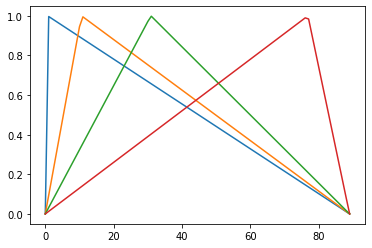

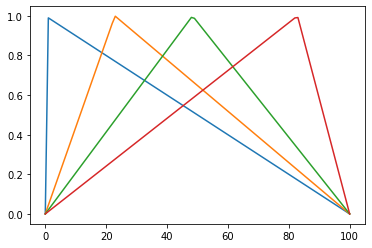

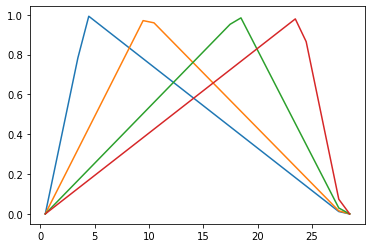

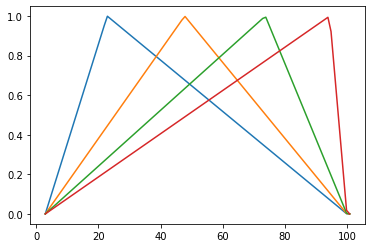

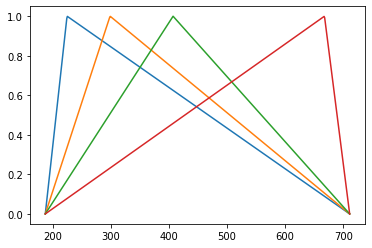

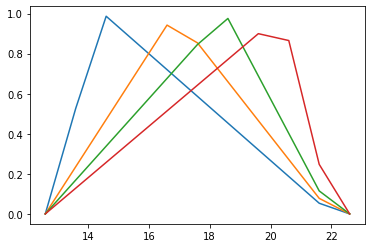

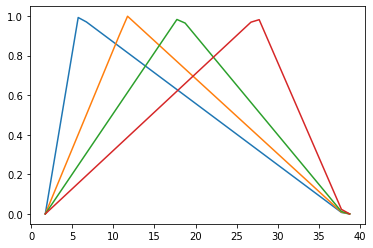

In [7]:
from fuzzylogic.classes import Domain
from matplotlib import pyplot as plt

for key, value in models.items():
  plt.figure()
  X_col = X[key]
  col_min = X_col.min()
  col_max = X_col.max()
  exec(f'{key} = Domain(key, col_min, col_max)')
  for i, rank in enumerate(['very_low', 'low', 'high', 'very_high']):
     exec(f'{key}.{rank} = make_fuzzy_set(col_min, col_max, value[{i}])')
     exec(f'{key}.{rank}.plot()')

2.3 Creating fuzzy variable for target variable

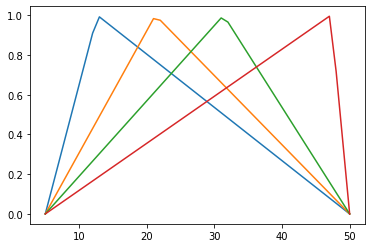

In [8]:
y_min = y.min()
y_max = y.max()
exec(f'{y.name} = Domain(y.name, y_min, y_max)')
for i, rank in enumerate(['very_low', 'low', 'high', 'very_high']):
  exec(f'{y.name}.{rank} = make_fuzzy_set(y_min, y_max, y_centers[{i}])')
  exec(f'{y.name}.{rank}.plot()')


#3. Rules learning

3.1 Fitting naive bayes

In [9]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_clust, y_labels)

model.feature_log_prob_

array([[-3.43504429, -2.68610575, -1.90401108, -1.62433973, -1.58749346,
        -1.60311878, -1.91112855],
       [-3.06267176, -2.4921269 , -3.22972584, -1.5671781 , -1.55008367,
        -1.6573292 , -1.51674725],
       [-1.65119348, -4.98848706, -1.84064701, -1.47907609, -2.04404808,
        -3.15020758, -1.41694431],
       [-4.71081638, -2.04160601, -3.56568407, -1.65951425, -1.46376967,
        -1.52682781, -1.63944669]])

3.2 Sampling feature combinations

In [10]:
from itertools import product

X_comb = []
for comb in product(*len(X_clust.columns)*[[0, 1, 2, 3]]):  # n_cluster
  X_comb.append(comb)
X_comb = pd.DataFrame(X_comb, columns=X_clust.columns)

X_comb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16384 entries, 0 to 16383
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   CRIM     16384 non-null  int64
 1   ZN       16384 non-null  int64
 2   INDUS    16384 non-null  int64
 3   AGE      16384 non-null  int64
 4   TAX      16384 non-null  int64
 5   PTRATIO  16384 non-null  int64
 6   LSTAT    16384 non-null  int64
dtypes: int64(7)
memory usage: 896.1 KB


3.3 Predicting labels for sampled combinations

In [11]:
preds = model.predict(X_comb)
df = X_comb.copy()
df['pred'] = preds
df.to_csv('disc_data_with_preds.csv')

preds[:10]
print(set(preds))

{0, 1, 2, 3}


#4. Fuzzy inference

4.1 Mapping labels to fuzzy sets

In [12]:
map = {0: 'very_low',
      1: 'low',
      2: 'high',
      3: 'very_high'}

4.2 Composing inference rules from sampled feature combinations and predicted labels

In [13]:
from fuzzylogic.classes import Rule

rules = []
for i, row in X_comb.iterrows():
  cond = []
  for col in X_comb.columns:
    cond.append('.'.join([col, map[row[col]]]))
  cond = ', '.join(cond)
  cons = '.'.join([y.name, map[preds[i]]])
  rules.append(f'({cond}): {cons}')

rules = eval('Rule({' + ',\n'.join(rules) + ',})')

rules

4.3 Formatting input data for inference

In [14]:
X_test = X[:200]
values = []
for i, row in X_test.iterrows():
  value = {}
  for col in X_test.columns:
    value[eval(col)] = row[col]
  values.append(value)

values[:5]

[{Domain('CRIM', 0.00632, 88.9762, res=1, sets={'very_low': Set(<function triangular.<locals>.f at 0x7f721d115c10>), 'low': Set(<function triangular.<locals>.f at 0x7f721d0783a0>), 'high': Set(<function triangular.<locals>.f at 0x7f721d078af0>), 'very_high': Set(<function triangular.<locals>.f at 0x7f721d07f280>)}): 0.00632,
  Domain('ZN', 0.0, 100.0, res=1, sets={'very_low': Set(<function triangular.<locals>.f at 0x7f721d07ff70>), 'low': Set(<function triangular.<locals>.f at 0x7f721d035700>), 'high': Set(<function triangular.<locals>.f at 0x7f721d035e50>), 'very_high': Set(<function triangular.<locals>.f at 0x7f721d03d5e0>)}): 18.0,
  Domain('INDUS', 0.46, 27.74, res=1, sets={'very_low': Set(<function triangular.<locals>.f at 0x7f721d045310>), 'low': Set(<function triangular.<locals>.f at 0x7f721cff28b0>), 'high': Set(<function triangular.<locals>.f at 0x7f721cffb0d0>), 'very_high': Set(<function triangular.<locals>.f at 0x7f721cffb790>)}): 2.31,
  Domain('AGE', 2.9, 100.0, res=1, se

4.4 Running fuzzy inference

In [15]:
preds = [rules(x) for x in values]

preds[:10]

[None,
 None,
 None,
 None,
 None,
 None,
 24.45954211341252,
 24.35156526302093,
 24.12364095086782,
 24.326259539437405]

#5. Comparing accuracy

5.1 Matching inference result with true labels

In [16]:
y_test = y[:200]
df_test = pd.DataFrame(data = {'y_pred': preds, 'y_true': y_test})
df_test = df_test.dropna()

df_test

,y_pred,y_true
6,24.459542,22.9
7,24.351565,27.1
8,24.123641,16.5
9,24.326260,18.9
10,24.260535,15.0
11,24.430015,18.9
12,24.459542,21.7
39,24.459542,30.8
40,24.116547,34.9
50,24.456444,19.7


5.2 MSE for fuzzy inference

In [17]:
from sklearn.metrics import mean_squared_error

mean_squared_error(df_test['y_true'], df_test['y_pred'])

36.74399692003634

5.3 MSE for linear regression



In [18]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)
preds = model.predict(X_test)

mean_squared_error(y_test, preds)

26.126730594282854